In [1]:
# Manipulação de Dados
import pickle
import numpy as np
import pandas as pd

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

# Otimização
from skopt import gp_minimize, BayesSearchCV
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Configurando o estilo de gráfico utilizado
%matplotlib inline
plt.rcParams["figure.figsize"] = 20, 10
plt.style.use('fivethirtyeight')

# Ignorando os avisos
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carrega o dataset com preços de alugueis da cidade de São Paulo
df = pd.read_csv('sao-paulo-properties.csv')

In [3]:
# Substituindo " " por "_" nos nomes das variáveis
df.columns = df.columns.str.replace(' ', '_')

In [4]:
# Dataset com preços de alugéis de imóveis
sale = df[df['Negotiation_Type'] == 'sale']
sale.reset_index(drop=True, inplace=True)

In [5]:
# Criando a variável "Comercial"
sale['Comercial'] = (sale['Price'] >= 8000) | (sale['Size'] >= 200)
sale['Comercial'] = sale['Comercial'].map({True: 1, False: 0})
  
# Valor do metro quadrado por apartamento
sale['m2_Value'] = np.round((sale['Price'] + sale['Condo']) / sale['Size'], 2)

In [6]:
# Lista de variáveis para exclusão
to_drop = ['New', 'District', 'Negotiation_Type', 'Property_Type', 'Latitude', 'Longitude']

# Exclui a variável "Property_Type" de dados
sale.drop(to_drop, axis=1, inplace=True)

sale.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,Comercial,m2_Value
0,732600,1000,74,1,2,1,2,1,0,1,1,9913.51
1,1990000,2400,164,4,5,2,3,1,1,1,1,12148.78
2,720000,700,70,2,2,1,1,1,0,1,1,10295.71
3,1680000,1580,155,3,5,3,2,1,0,1,1,10848.90
4,1200000,900,56,2,2,1,2,0,1,1,1,21444.64


In [7]:
# Seleciona os atributos e a variável alvo para a divisão
X = sale.drop('Price', axis=1)
y = sale['Price']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
# Cria uma função com as métricas de avaliação
def performace(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return (print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAE das previsões é {}'.format(round(mae, 2))))

Random Forest Regressor: -5557449309.693553 (4713286638.946020)
Gradient Boosting Regressor: -3691836526.629922 (2691010654.933923)
XGBoost Regressor: -4001399596.831522 (3889817561.968850)
CatBoost Regressor: -5058717024.873889 (5586610875.362445)
Light Gradient Boosting Regressor: -9004593873.084770 (7648276842.171659)


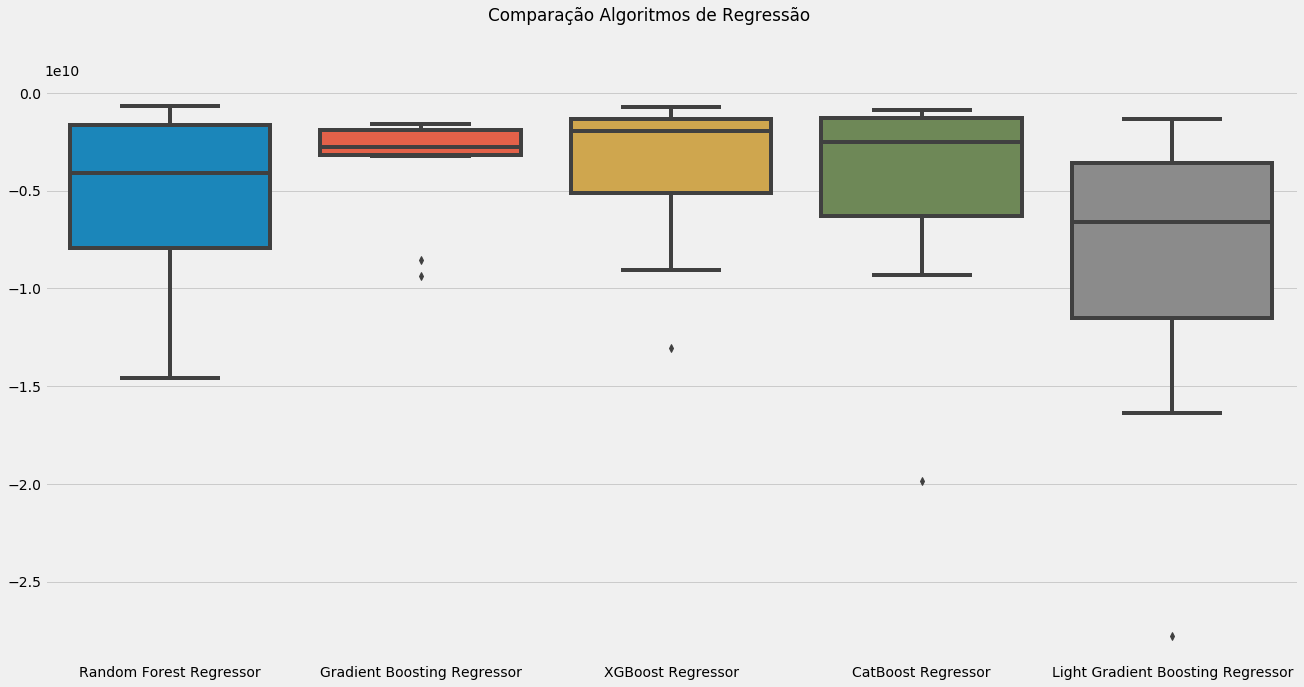

In [9]:
# Instanciando e criando uma lista com os modelos
modelos = []
modelos.append(('Random Forest Regressor', RandomForestRegressor(random_state=42)))
modelos.append(('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42)))
modelos.append(('XGBoost Regressor', XGBRegressor(random_state=42)))
modelos.append(('CatBoost Regressor', CatBoostRegressor(random_state=42, verbose=False)))
modelos.append(('Light Gradient Boosting Regressor', LGBMRegressor(random_state=42)))

# Lista de resultados e nomes dos modelos
resultados = []
nomes = []

# Seleção do melhor modelo por meio de uma validação cruzada
for nome, modelo in modelos:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(modelo, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = '%s: %f (%f)' % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Box-plot dos modelos
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparação Algoritmos de Regressão')
ax = fig.add_subplot(111)
sns.boxplot(x=nomes, y=resultados)
ax.set_xticklabels(nomes)
plt.show()

In [10]:
# Instancia do Gradient Boosting Regressor
gradboost = GradientBoostingRegressor(random_state=42)

# Treina o modelo
gradboost.fit(X_train, y_train)

# Armazena as previsões em uma variável
pred = gradboost.predict(X_test)

# Realiza a avalição por meio da função perfomace
performace(y_test, pred)

MSE das previsões é 3002686944.1
RMSE das previsões é 54796.78
MAE das previsões é 23671.48


In [11]:
# Instanciando o modelo
gbr_reg = GradientBoostingRegressor(random_state=42)

# A lista de hiperparâmetros que queremos otimizar. 
space  = [Real(1e-5, 1e-1, 'log-uniform', name='learning_rate'),
          Integer(100, 2500, name='n_estimators'),
          Integer(1, 25, name= 'max_depth'),
          Real(0.05, 1.0, name='subsample'),
          Integer(2, 50, name='min_samples_split'),
          Integer(1, 50, name='min_samples_leaf'),
          Integer(1, 11, name='max_features')]

# permite que sua função objetivo receba os parâmetros como argumentos de palavras-chave.
@use_named_args(space)
def objective(**params):
    gbr_reg.set_params(**params)

    return -np.mean(cross_val_score(gbr_reg, 
                                    X_train, 
                                    y_train, 
                                    cv=10, 
                                    n_jobs=-1, 
                                    scoring="neg_mean_squared_error"))

In [12]:
# Buscando os melhores hiperparâmetros
gbr_gp = gp_minimize(objective,          # Função a ser minimizada
                     space,              # Espaços dos hiperparâmetros a ser otimizado
                     n_calls=50,         # Número de rodadas para otimização
                     n_random_starts=10, # Número de avaliações de pontos aleatórios antes de aproximar a função.
                     random_state=42, 
                     verbose=1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 25.7751
Function value obtained: 5677350153.9691
Current minimum: 5677350153.9691
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.9858
Function value obtained: 519934400903.8854
Current minimum: 5677350153.9691
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.2268
Function value obtained: 102771027401.3685
Current minimum: 5677350153.9691
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 30.1004
Function value obtained: 523288380522.6415
Current minimum: 5677350153.9691
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 50.7787
Function 

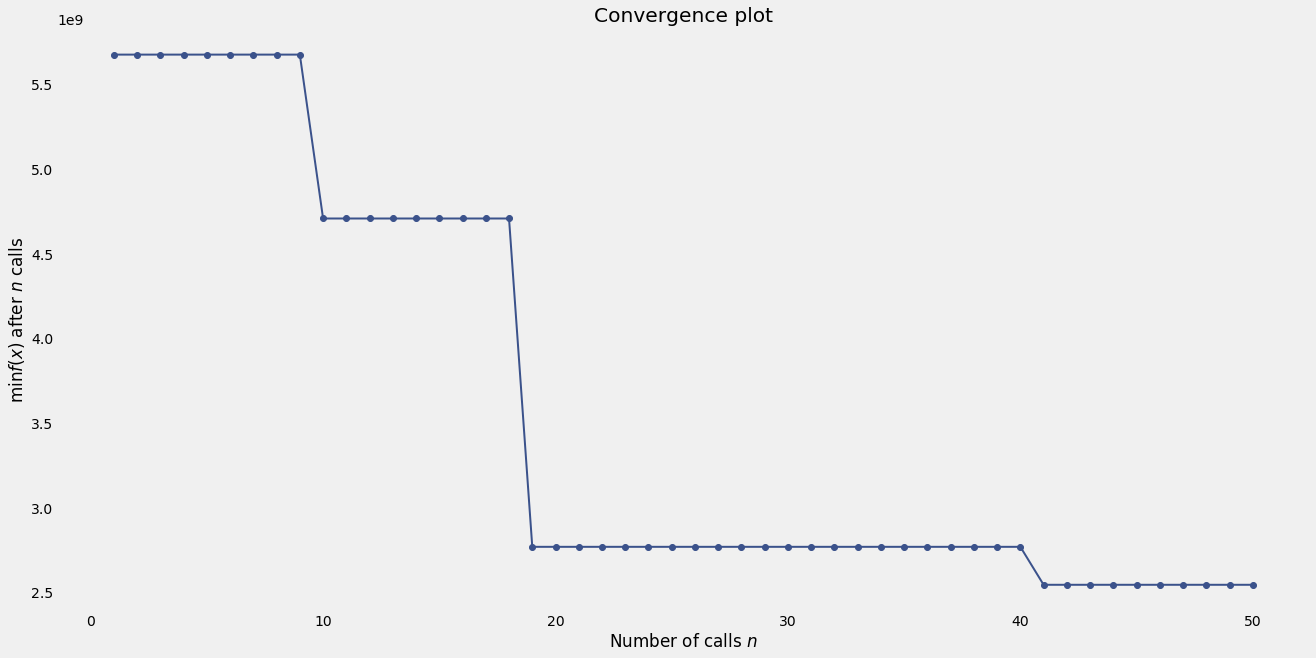

In [13]:
# Plot da convergência do Processo Gaussiano.
plot_convergence(gbr_gp)
plt.show()

In [14]:
# Hiperparâmetros escolhidos durante a otimização
print('Melhores parâmetros para maximização do MSE score: ', gbr_gp.x)

Melhores parâmetros para maximização do MSE score:  [0.0041833415347302455, 1746, 9, 0.4494152446058108, 6, 1, 9]


In [15]:
# Instanciando o modelo com os melhores parâmetros
gbr_opt = GradientBoostingRegressor(learning_rate=0.0041833415347302455, 
                                    n_estimators=1746, 
                                    max_depth=9,
                                    subsample=0.4494152446058108,
                                    min_samples_split=6,
                                    min_samples_leaf=1,
                                    max_features=9,
                                    random_state=42)
    
# Treinando o modelo com as variáveis selecionadas
gbr_opt.fit(X_train, y_train)

# Realizando as previsões
pred = gbr_opt.predict(X_test)

In [16]:
# Realiza a avalição por meio da função perfomace
performace(y_test, pred)

MSE das previsões é 1970285444.27
RMSE das previsões é 44387.9
MAE das previsões é 8612.12


In [17]:
# Dump do modelo
pickle.dump(gbr_opt, open('Model/Sales_GradBoost.pkl', 'wb'))